In [1]:
from functools import partial
from pathlib import Path

import numpy as np
import jax
import jax.numpy as jnp
import orbax.checkpoint as ocp
import umap
from tqdm import tqdm
import matplotlib.pyplot as plt
import pprint

print(jax.default_backend())

cell_types = eval(open("ref_data/tome_cell_types").read())
cell_types_sorted = sorted(cell_types.keys())
mapping_r = [cell_types[k] for k in cell_types_sorted]
mapping = np.argsort(mapping_r)

import tensorflow as tf

/home/FCAM/jyu/work/chioso/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu


In [2]:
# define data dirs

checkpoint_dir = "predictor_log"
config_dir = "../configs"


In [3]:
import sys
sys.path.append(config_dir)

import cfg_predictor
config = cfg_predictor.get_config()

#override
# config.model.config.log_transform=False

model = config.model.type(**config.model.config)
params = ocp.StandardCheckpointer().restore(
    (Path(checkpoint_dir)/"checkpoint").absolute(),
)["train_state"]["params"]

pprint.pp(model)

LinearPredictor(
    # attributes
    n_genes = 27504
    dim_out = 68
    dim_hidden = 256
    n_layers = 6
    dropout = 0.2
    normalize = False
    log_transform = False
)


2024-06-01 16:16:37.596775: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
padding = config.dataset.get("padding", 4096)
val_frac = config.train.get("val_split", 0.2)

ds = tf.data.Dataset.load("ref_data/tome.ds/")

ds_val = (
    ds
    .enumerate()
    .filter(lambda i, _: int(float(i+1) * val_frac) > int(float(i) * val_frac))
    .map(lambda _, x: x)
    .map(lambda gid, cnt, gt: ((gid, cnt), gt))
    .padded_batch(
        config.train.batchsize,
        padded_shapes=(
            ([padding], [padding]), [],
        ),
        drop_remainder=True,
    )
    .prefetch(1)
)

In [5]:
y_true, y_pred = [], []
for inputs, y_true_ in tqdm(ds_val.as_numpy_iterator()):
    pred_logits = jax.jit(jax.vmap(model.apply, in_axes=[None, 0, 0]))(dict(params=params), *inputs)
    y_pred.append(np.argmax(pred_logits, axis=-1))
    y_true.append(np.asarray(y_true_))
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)    

2177it [12:08,  2.98it/s]2024-06-01 16:28:46.309483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2177it [12:08,  2.99it/s]


In [6]:
from sklearn.metrics import *

print(f"balanced accuracy:  {balanced_accuracy_score(y_true, y_pred)}")
print(f"accuracy:  {accuracy_score(y_true, y_pred)}")
print(f"precision:  {precision_score(y_true, y_pred, average='weighted')}")
print(f"recall:  {recall_score(y_true, y_pred, average='weighted')}")

balanced accuracy:  0.8751725289540035
accuracy:  0.8296142914561323
precision:  0.8411675068308722
recall:  0.8296142914561323


Text(0.5, 1.0, 'Confusion Matric')

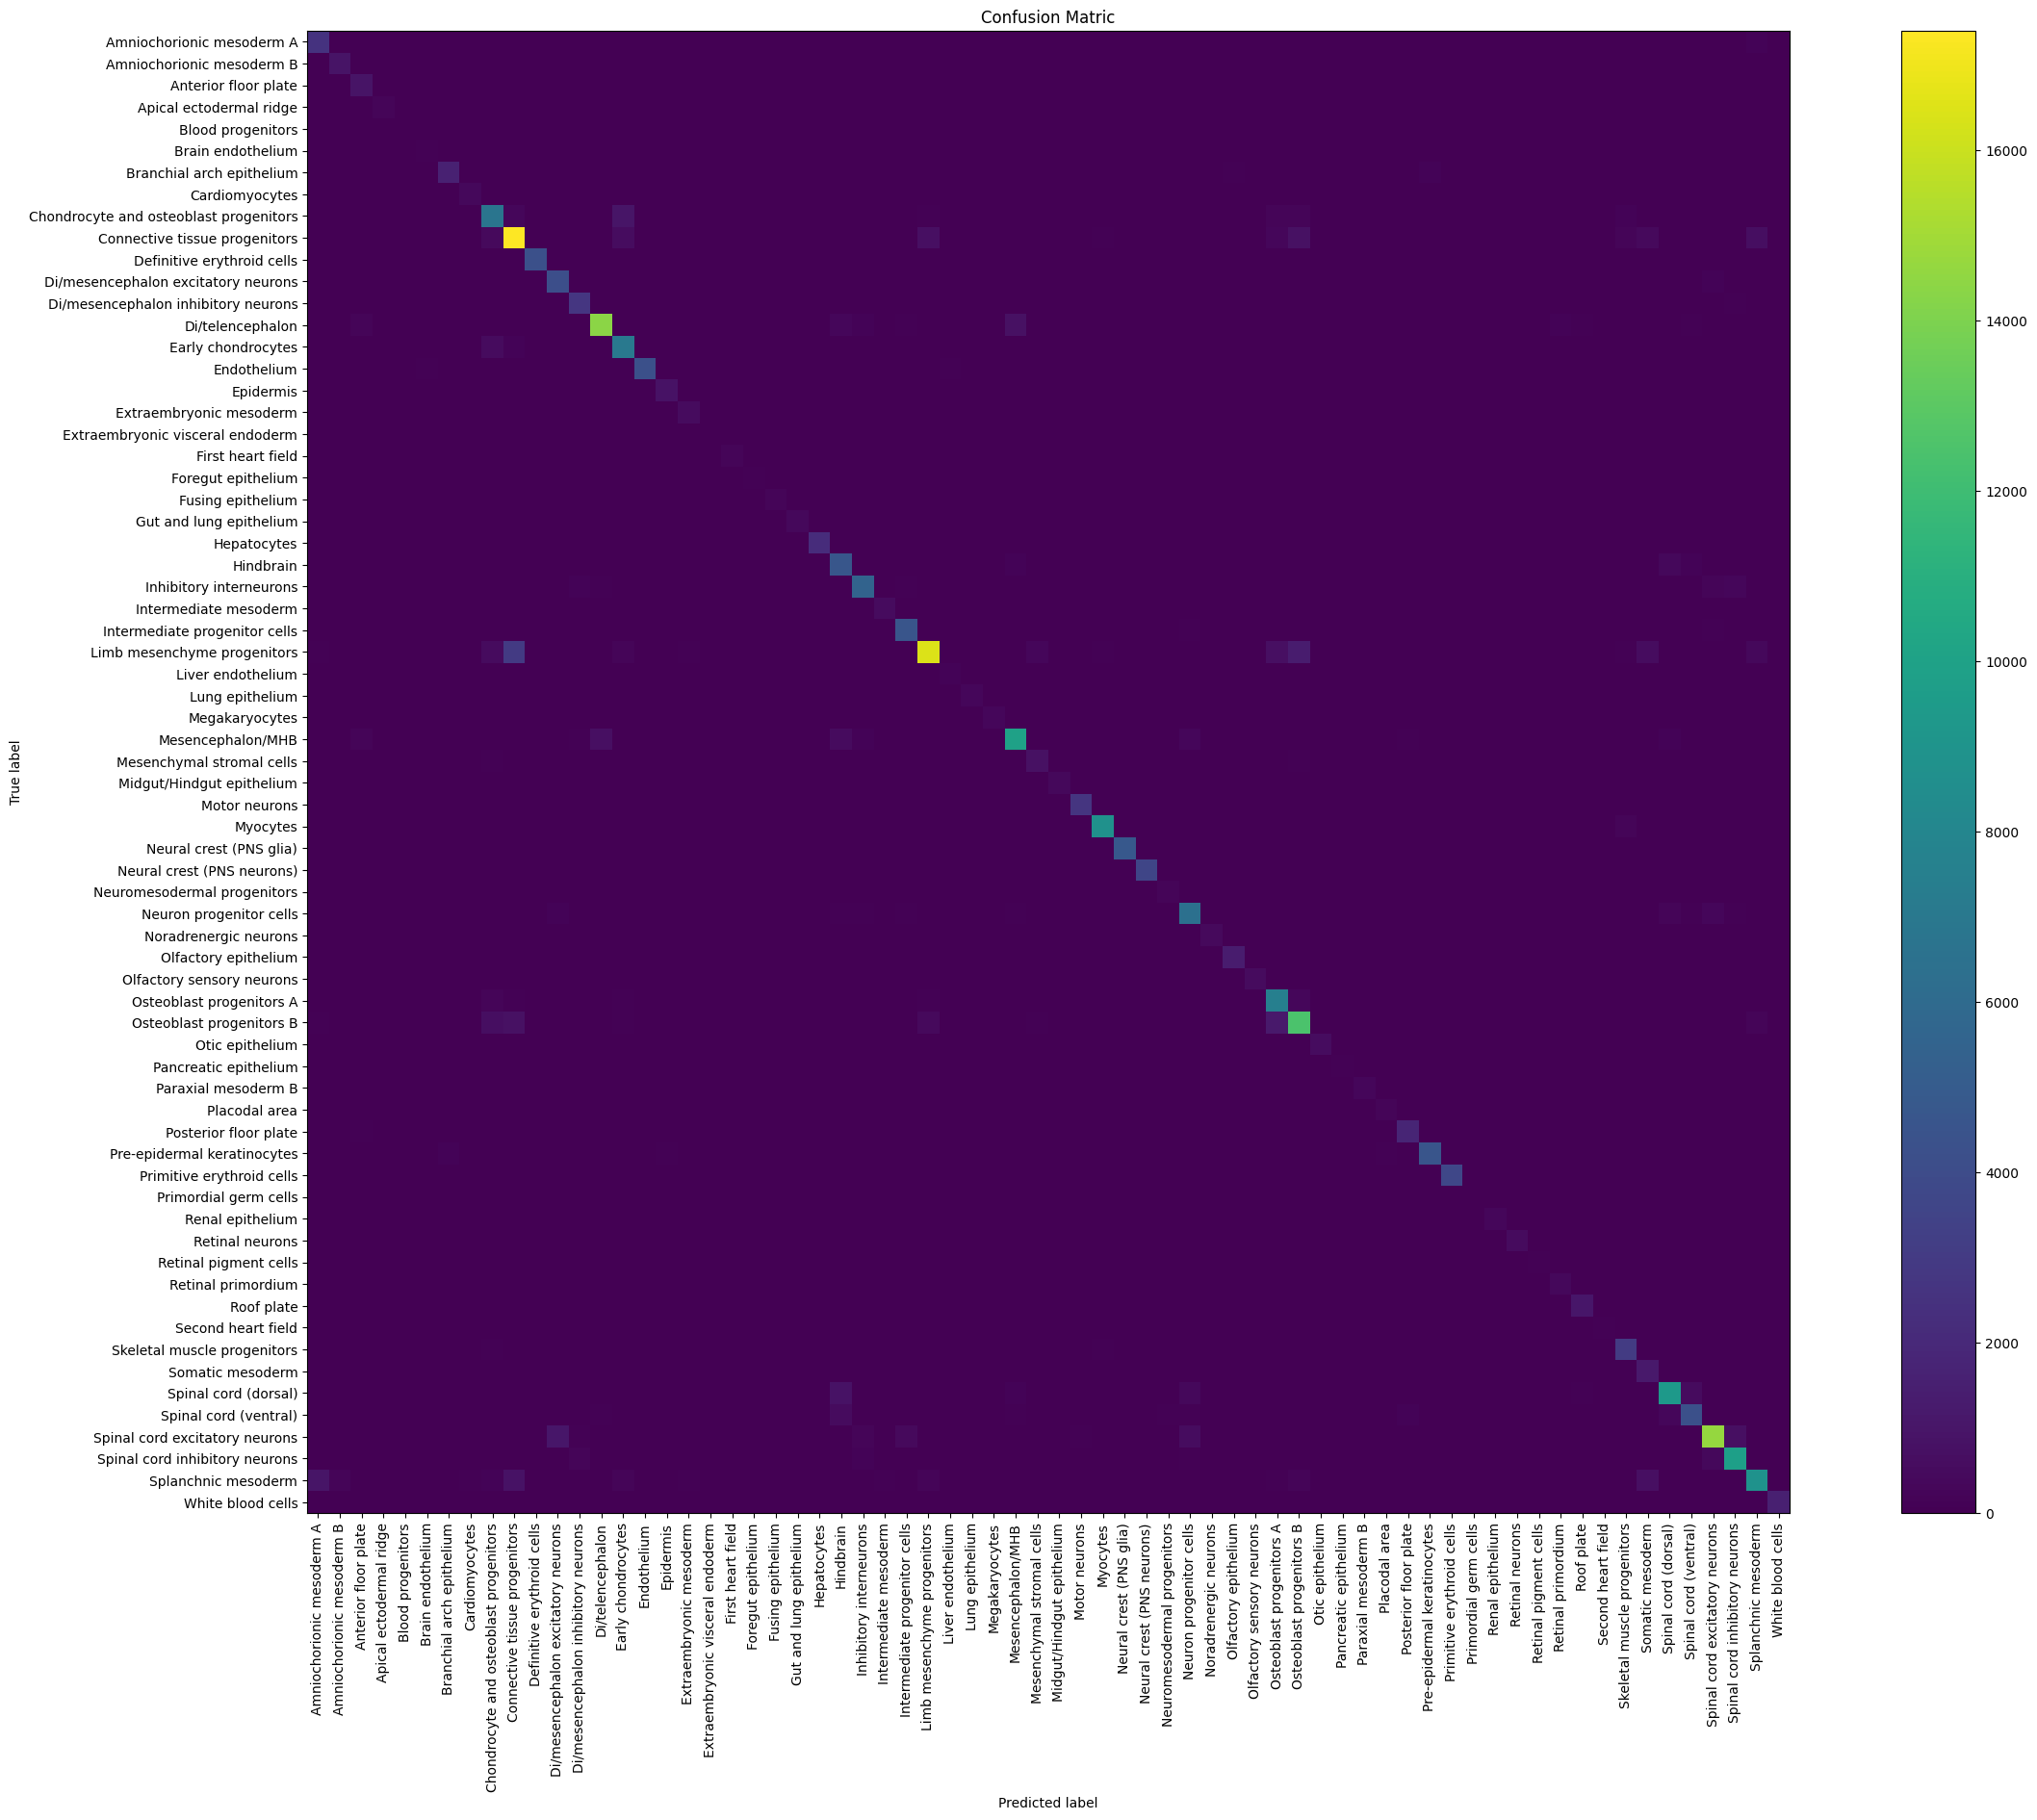

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(30,20))
disp = ConfusionMatrixDisplay.from_predictions(
    mapping[y_true], mapping[y_pred], 
    ax = ax, 
    include_values=False, 
    display_labels=cell_types_sorted, 
    xticks_rotation="vertical",
)
ax.set_title("Confusion Matric")

In [9]:
embed = np.stack(
    list(tf.data.Dataset.load(str(Path(checkpoint_dir)/"ref_embedding.ds")).batch(256).map(lambda x: x[0]).as_numpy_iterator())
)

latent_y_true = np.stack(tuple(ds.map(lambda a, b, c: c).batch(256).map(lambda x: x[0]).as_numpy_iterator()))

def _apply_fn(mdl, x):
    return mdl.mlp(x, deterministic=True)

apply_fn = jax.jit(partial(model.apply, method=_apply_fn, mutable="intermediates"))

_, latent = apply_fn(dict(params=params), embed)
latent = latent["intermediates"]["mlp"]["latent"][0]

2024-06-01 16:29:33.805441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-01 16:30:05.422583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0, 0.5, 'UMAP-2')

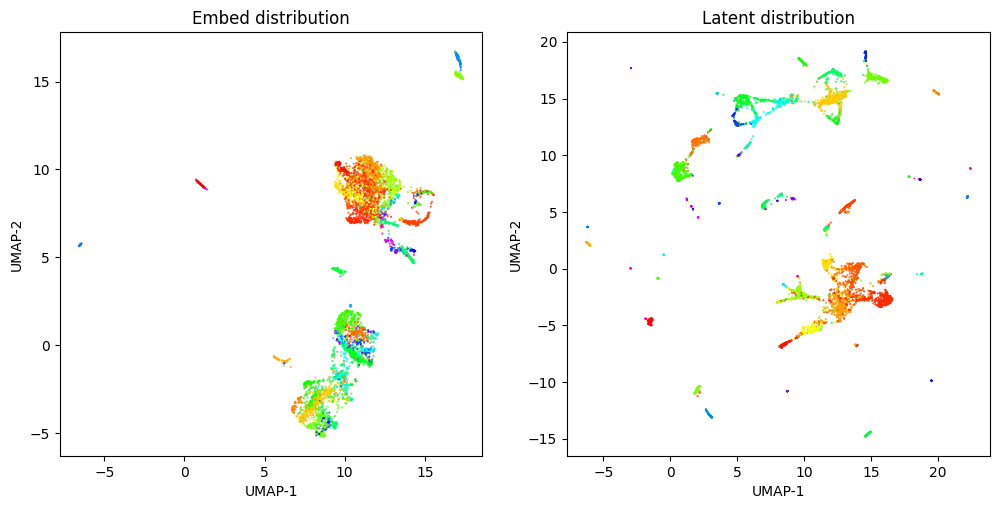

In [10]:
d = umap.UMAP()
embed_reduced = d.fit_transform(embed)
latent_reduced = d.fit_transform(latent)

fig, ax = plt.subplots(1,2,figsize=(12,5.5))

p1 = ax[0].scatter(embed_reduced[:, 0], embed_reduced[:, 1], s=0.2, c=latent_y_true, cmap="hsv")
ax[0].set_title("Embed distribution")
ax[0].set_xlabel("UMAP-1")
ax[0].set_ylabel("UMAP-2")

p2 = ax[1].scatter(latent_reduced[:, 0], latent_reduced[:, 1], s=0.2, c=latent_y_true, cmap="hsv")
ax[1].set_title("Latent distribution")
ax[1].set_xlabel("UMAP-1")
ax[1].set_ylabel("UMAP-2")

In [11]:
from sklearn.metrics import classification_report

y0 = mapping[y_true]
y1 = mapping[y_pred]

names = [ "'" + x + "'" for x in cell_types_sorted]

print(classification_report(y0, y1, target_names=np.array(names)))

                                          precision    recall  f1-score   support

             'Amniochorionic mesoderm A'       0.66      0.90      0.76      2856
             'Amniochorionic mesoderm B'       0.71      0.90      0.80      1005
                  'Anterior floor plate'       0.60      0.92      0.73      1021
               'Apical ectodermal ridge'       0.78      0.92      0.85       242
                     'Blood progenitors'       0.41      0.41      0.41        37
                     'Brain endothelium'       0.50      0.94      0.65       138
             'Branchial arch epithelium'       0.83      0.74      0.78      2152
                        'Cardiomyocytes'       0.60      0.85      0.70       408
'Chondrocyte and osteoblast progenitors'       0.71      0.75      0.73      9070
         'Connective tissue progenitors'       0.77      0.80      0.78     21775
            'Definitive erythroid cells'       0.96      0.97      0.96      4359
   'Di/mesencep